In [486]:
import pandas as pd
df_orig = pd.read_excel('default_of_credit_card_clients.xls')

In [487]:
df_zero_mask = df_orig == 0
feature_zero_mask = df_zero_mask.iloc[:,1:].all(axis=1)

In [488]:
sum(feature_zero_mask)

315

In [489]:
df_clean = df_orig.loc[~feature_zero_mask,:].copy()
df_clean.shape

(29685, 25)

In [490]:
df_clean['ID'].nunique()

29685

In [491]:
df_clean['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True)
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)

In [492]:
df_clean['PAY_1'].value_counts()

0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: PAY_1, dtype: int64

In [493]:
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'

In [494]:
sum(missing_pay_1_mask)

3021

In [495]:
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask,:].copy()

In [496]:
df = pd.read_csv('cleaned_data.csv')

In [497]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'EDUCATION_CAT', 'graduate school',
       'high school', 'others', 'university'],
      dtype='object')

In [498]:
features_response = df.columns.tolist()

In [499]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [500]:
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [501]:
import numpy as np
from sklearn.model_selection import train_test_split

In [502]:
X_train, X_test, y_train, y_test = \
train_test_split(df[features_response[:-1]].values, df['default payment next month'].values,
test_size=0.2, random_state=24)

In [503]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21583, 17)
(5396, 17)
(21583,)
(5396,)


In [504]:
features_response[4]

'PAY_1'

In [505]:
np.median(X_train[:,4])

0.0

In [506]:
np.random.seed(seed=1)
fill_values = [0, np.random.choice(X_train[:,4], size=(3021,), replace=True)]

In [507]:
fill_strategy = ['mode', 'random']

In [508]:
fill_values[-1]

array([ 0,  0,  0, ...,  1, -1,  1], dtype=int64)

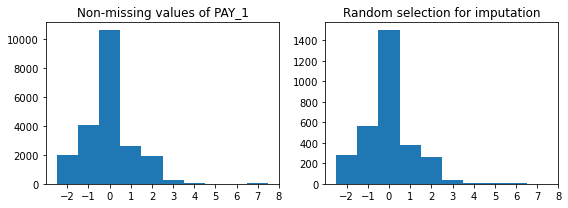

In [509]:
import matplotlib.pyplot as plt #plotting package
%matplotlib inline
fig, axs = plt.subplots(1,2, figsize=(8,3))
bin_edges = np.arange(-2,9)
axs[0].hist(X_train[:,4], bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(fill_values[-1], bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Random selection for imputation')
plt.tight_layout()

In [510]:
from sklearn.model_selection import KFold
k_folds = KFold(n_splits=4, shuffle=True, random_state=1)

In [511]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=200, criterion='gini', max_depth=9,
    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
    max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
    min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
    random_state=4, verbose=1, warm_start=False, class_weight=None)

In [512]:
for counter in range(len(fill_values)):
    #Copy the data frame with missing PAY_1 and assign imputed values
    df_fill_pay_1_filled = df_missing_pay_1.copy()
    df_fill_pay_1_filled['PAY_1'] = fill_values[counter]
    #Split imputed data in to training and testing, using the same
    #80/20 split we have used for the data with non-missing PAY_1
    X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
    train_test_split(
        df_fill_pay_1_filled[features_response[:-1]].values,
        df_fill_pay_1_filled['default payment next month'].values,
    test_size=0.2, random_state=24)
    #Concatenate the imputed data with the array of non-missing data
    X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
    y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
    #Use the KFolds splitter and the random forest model to get
    #4-fold cross-validation scores for both imputation methods
    imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
        cv=k_folds, n_jobs=-1, verbose=1,
        return_train_score=True, return_estimator=True,
        error_score='raise-deprecating')
 
    test_score = imputation_compare_cv['test_score']
    print(fill_strategy[counter] + ' imputation: ' +
          'mean testing score ' + str(np.mean(test_score)) +
          ', std ' + str(np.std(test_score)))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


mode imputation: mean testing score 0.7722864985184301, std 0.004671533355901269
random imputation: mean testing score 0.7698927874885768, std 0.005441816681109969


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   27.2s finished


In [513]:
pay_1_df = df.copy()

In [514]:
features_for_imputation = pay_1_df.columns.tolist()

In [515]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university', 'default payment next month', 'PAY_1']

In [516]:
features_for_imputation = [item for item in features_for_imputation if item not in items_to_remove]
features_for_imputation

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [517]:
X_impute_train, X_impute_test, y_impute_train, y_impute_test = \
train_test_split(
    pay_1_df[features_for_imputation].values,
    pay_1_df['PAY_1'].values,
test_size=0.2, random_state=24)

In [518]:
rf_impute_params = {'max_depth':[3, 6, 9, 12],
             'n_estimators':[10, 50, 100, 200]}

In [519]:
from sklearn.model_selection import GridSearchCV
cv_rf_impute = GridSearchCV(rf, param_grid=rf_impute_params, scoring='accuracy', n_jobs=-1, iid=False, refit=True,
cv=4, verbose=2, error_score=np.nan, return_train_score=True)

In [521]:
cv_rf_impute.fit(X_impute_train, y_impute_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  1.6min finished
C:\Users\Hrithik M Philip\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.8s finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=9, n_estimators=200,
                                              random_state=4, verbose=1),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=2)

In [522]:
cv_rf_impute.best_params_

{'max_depth': 12, 'n_estimators': 200}

In [523]:
cv_rf_impute.best_score_

0.7342814177391553

In [524]:
pay_1_value_counts = pay_1_df['PAY_1'].value_counts().sort_index()
pay_1_value_counts

-2     2476
-1     5047
 0    13402
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: PAY_1, dtype: int64

In [525]:
pay_1_value_counts/pay_1_value_counts.sum()

-2    0.091775
-1    0.187071
 0    0.496757
 1    0.120872
 2    0.088143
 3    0.010823
 4    0.002335
 5    0.000853
 6    0.000408
 7    0.000334
 8    0.000630
Name: PAY_1, dtype: float64

In [526]:
y_impute_predict = cv_rf_impute.predict(X_impute_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


In [527]:
from sklearn import metrics
metrics.accuracy_score(y_impute_test, y_impute_predict)

0.752594514455152

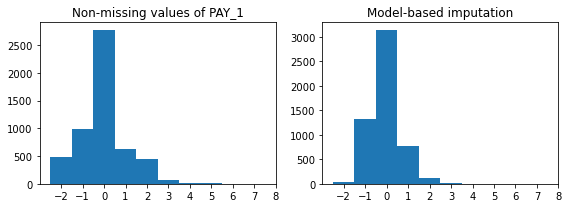

In [528]:
fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].hist(y_impute_test, bins=bin_edges, align='left')
axs[0].set_xticks(bin_edges)
axs[0].set_title('Non-missing values of PAY_1')
axs[1].hist(y_impute_predict, bins=bin_edges, align='left')
axs[1].set_xticks(bin_edges)
axs[1].set_title('Model-based imputation')
plt.tight_layout()

In [529]:
X_impute_all = pay_1_df[features_for_imputation].values
y_impute_all = pay_1_df['PAY_1'].values

In [530]:
rf_impute = RandomForestClassifier(n_estimators=100, max_depth=12)

In [531]:
rf_impute.fit(X_impute_all, y_impute_all)

RandomForestClassifier(max_depth=12)

In [532]:
df_fill_pay_1_model = df_missing_pay_1.copy()

In [533]:
df_fill_pay_1_model['PAY_1'].head()

17    Not available
28    Not available
29    Not available
54    Not available
60    Not available
Name: PAY_1, dtype: object

In [534]:
df_fill_pay_1_model['PAY_1'] = rf_impute.predict(df_fill_pay_1_model[features_for_imputation].values)

In [551]:
df_fill_pay_1_model['PAY_1'].head()

17    0
28   -1
29    0
54    0
60    0
Name: PAY_1, dtype: int64

In [552]:
df_fill_pay_1_model['PAY_1'].value_counts().sort_index()

-2      35
-1     763
 0    1722
 1     440
 2      50
 3       7
 4       2
 6       1
 7       1
Name: PAY_1, dtype: int64

In [553]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
    test_size=0.2, random_state=24)

In [554]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)

In [555]:
rf

RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [556]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
cv=k_folds, n_jobs=-1, verbose=1,
    return_train_score=True, return_estimator=True,
    error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.7s finished


In [557]:
np.mean(imputation_compare_cv['test_score'])

0.7726185453664808

In [558]:
df_fill_pay_1_model['PAY_1'] = np.zeros_like(df_fill_pay_1_model['PAY_1'].values)

In [559]:
df_fill_pay_1_model['PAY_1'].unique()

array([0], dtype=int64)

In [560]:
X_fill_pay_1_train, X_fill_pay_1_test, y_fill_pay_1_train, y_fill_pay_1_test = \
train_test_split(
    df_fill_pay_1_model[features_response[:-1]].values,
    df_fill_pay_1_model['default payment next month'].values,
test_size=0.2, random_state=24)

In [561]:
X_train_all = np.concatenate((X_train, X_fill_pay_1_train), axis=0)
X_test_all = np.concatenate((X_test, X_fill_pay_1_test), axis=0)
y_train_all = np.concatenate((y_train, y_fill_pay_1_train), axis=0)
y_test_all = np.concatenate((y_test, y_fill_pay_1_test), axis=0)

In [562]:
imputation_compare_cv = cross_validate(rf, X_train_all, y_train_all, scoring='roc_auc',
cv=k_folds, n_jobs=-1, verbose=1,
    return_train_score=True, return_estimator=True,
    error_score='raise-deprecating')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.6s finished


In [563]:
np.mean(imputation_compare_cv['test_score'])

0.7722864985184301

In [564]:
rf.fit(X_train_all, y_train_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.1s finished


RandomForestClassifier(max_depth=9, n_estimators=200, random_state=4, verbose=1)

In [565]:
y_test_all_predict_proba = rf.predict_proba(X_test_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [566]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_all, y_test_all_predict_proba[:,1])

0.7820680544835993

In [567]:
thresholds = np.linspace(0, 1, 101)

In [568]:
df[features_response[:-1]].columns[5]

'BILL_AMT1'

In [569]:
savings_per_default = np.mean(X_test_all[:, 5])
savings_per_default

51794.04182636227

In [570]:
cost_per_counseling = 7500

In [571]:
effectiveness = 0.70

In [572]:
n_pos_pred = np.empty_like(thresholds)
cost_of_all_counselings = np.empty_like(thresholds)
n_true_pos = np.empty_like(thresholds)
savings_of_all_counselings = np.empty_like(thresholds)
savings_based_on_balances = np.empty_like(thresholds)

In [573]:
counter = 0
for threshold in thresholds:
    pos_pred = y_test_all_predict_proba[:,1]>threshold
    n_pos_pred[counter] = sum(pos_pred)
    cost_of_all_counselings[counter] = n_pos_pred[counter] * cost_per_counseling
    true_pos = pos_pred & y_test_all.astype(bool)
    n_true_pos[counter] = sum(true_pos)
    savings_of_all_counselings[counter] = n_true_pos[counter] * savings_per_default * effectiveness
    counter += 1


In [574]:
net_savings = savings_of_all_counselings - cost_of_all_counselings

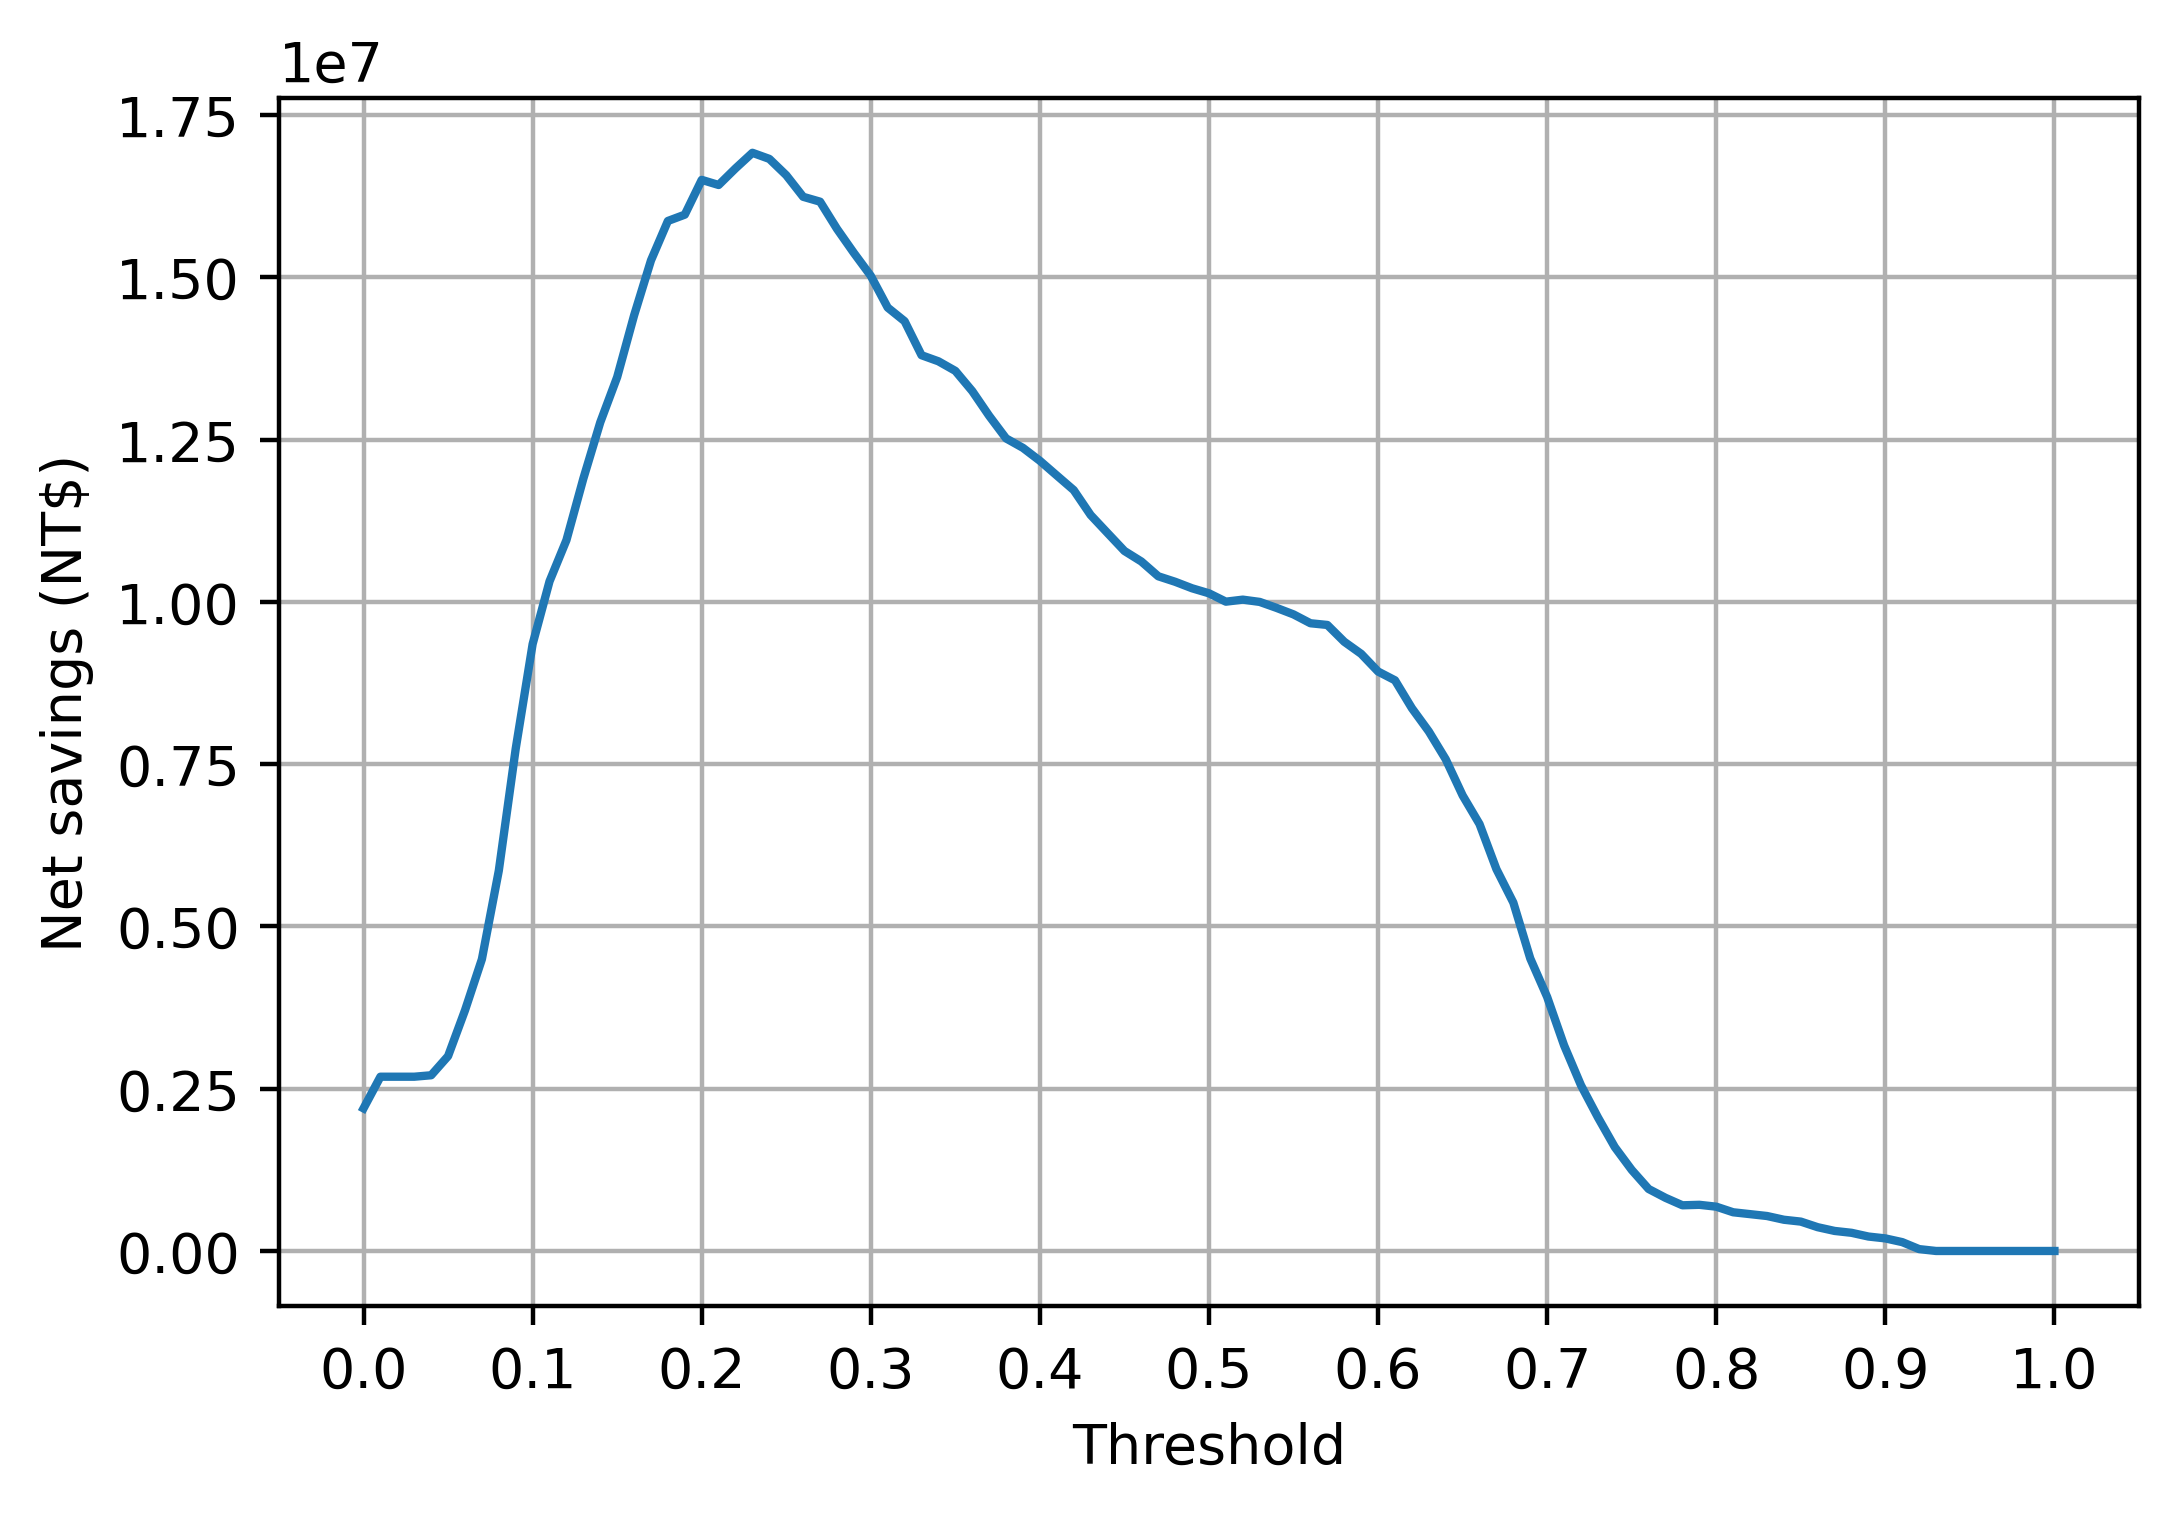

In [575]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
plt.plot(thresholds, net_savings)
plt.xlabel('Threshold')
plt.ylabel('Net savings (NT$)')
plt.xticks(np.linspace(0,1,11))
plt.grid(True)

In [576]:
max_savings_ix = np.argmax(net_savings)

In [577]:
thresholds[max_savings_ix]

0.23

In [578]:
net_savings[max_savings_ix]

16921059.154724207

Text(0, 0.5, 'Number of accounts')

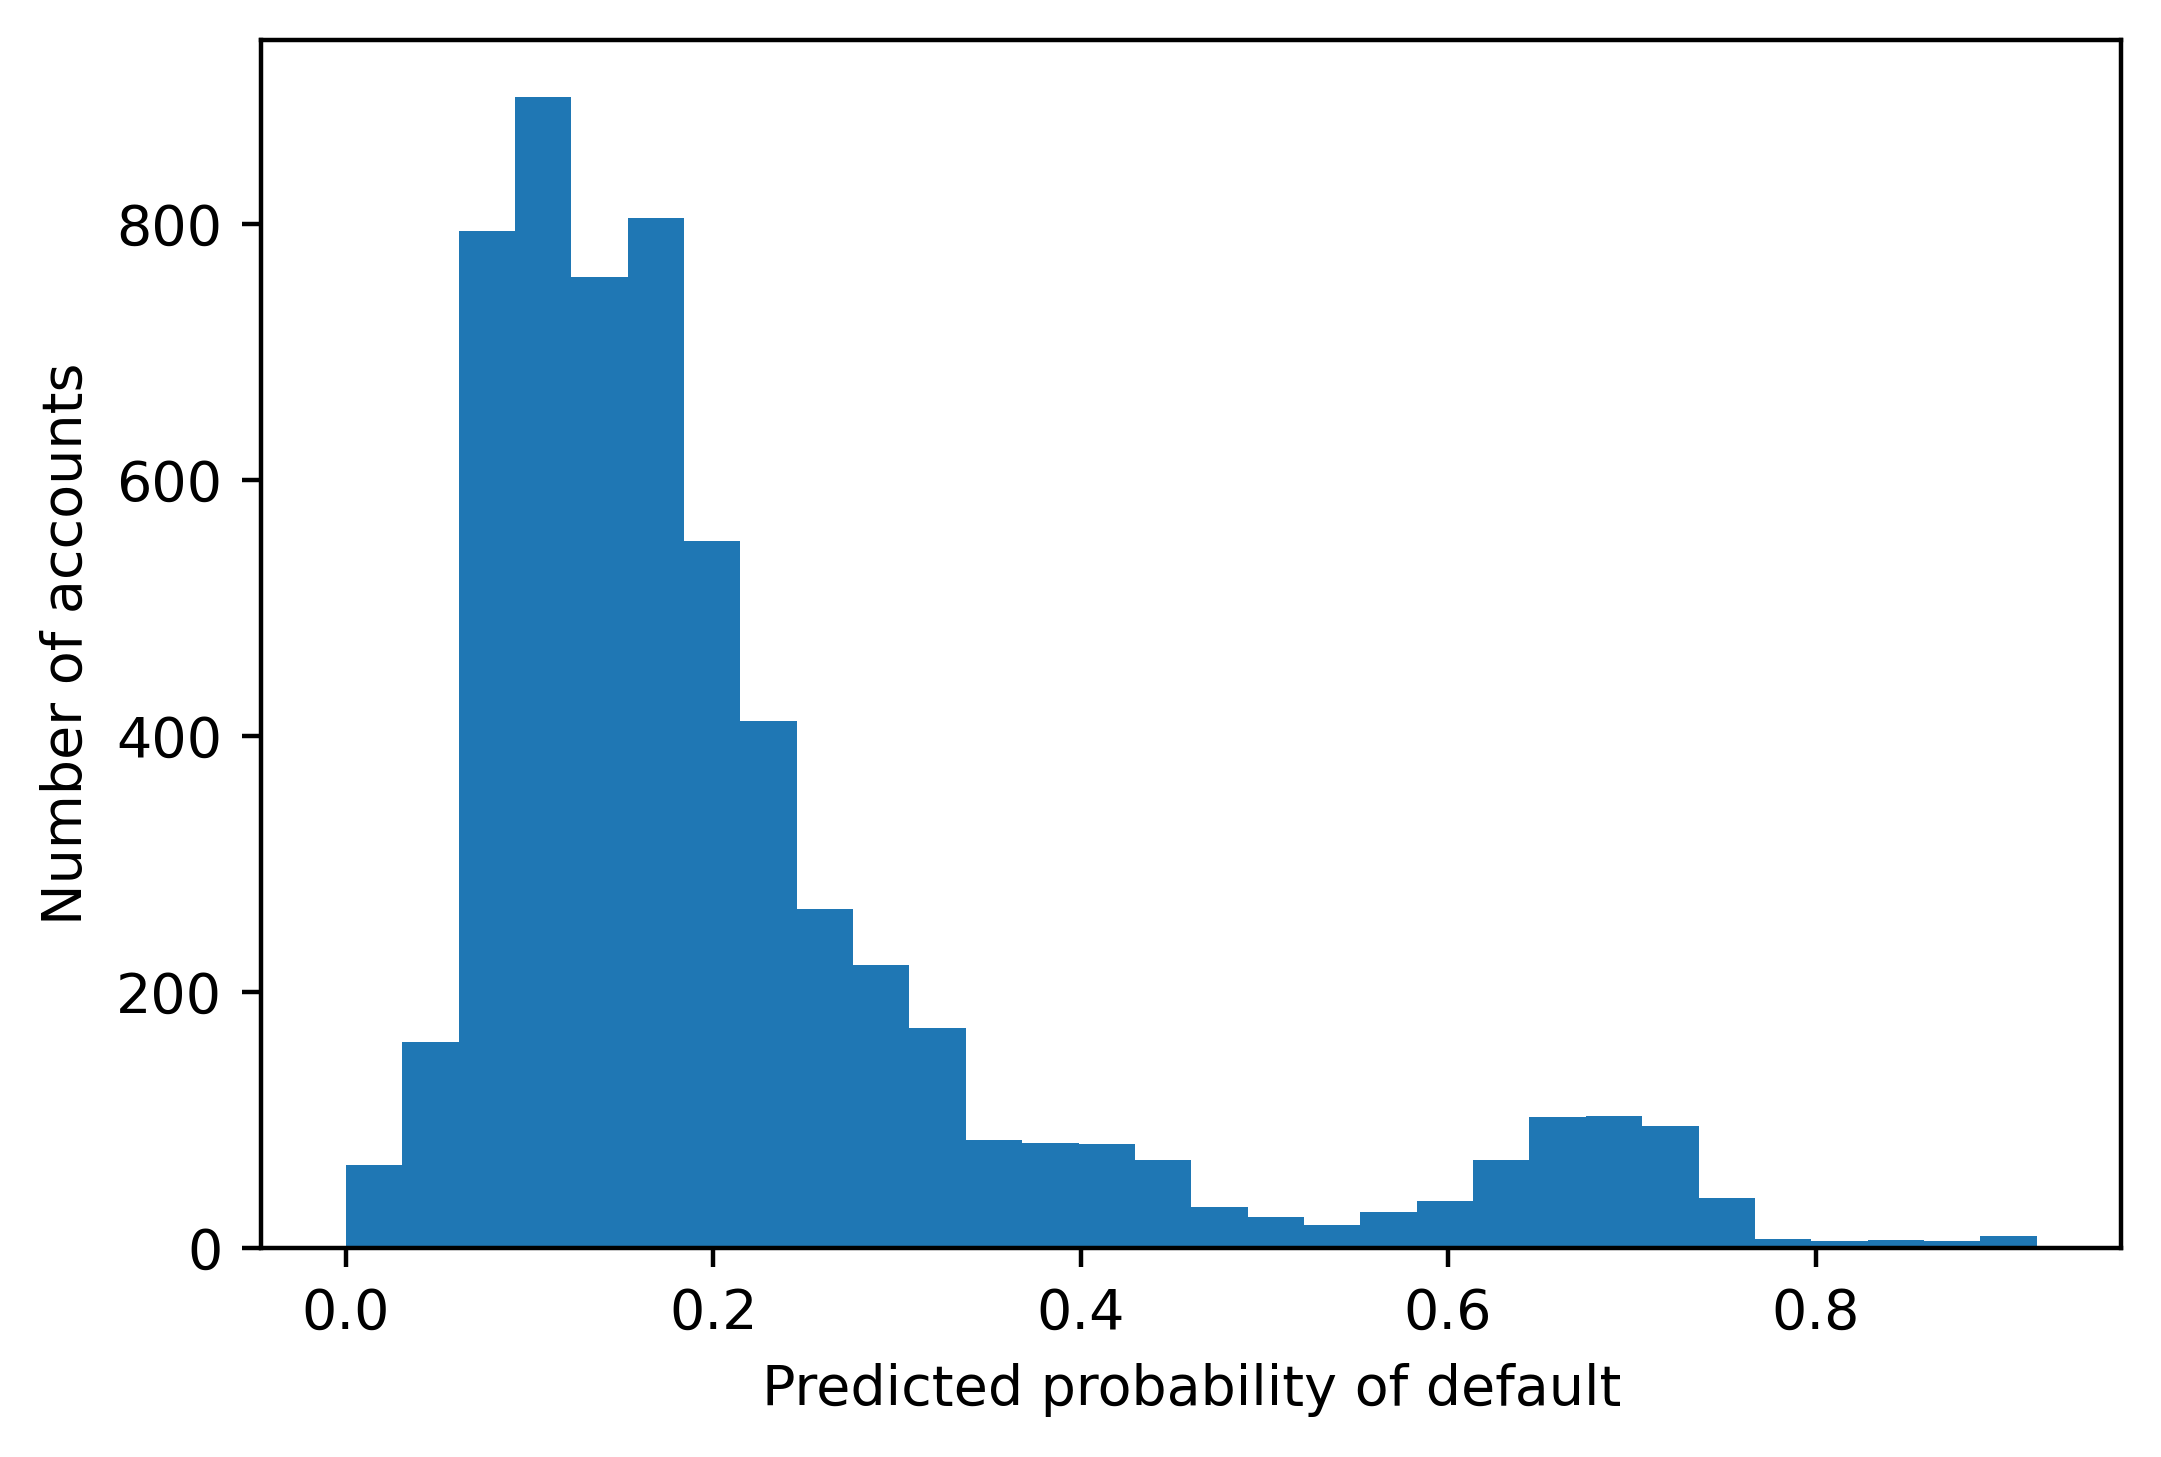

In [579]:
plt.hist(y_test_all_predict_proba[:,1], bins=30)
plt.xlabel('Predicted probability of default')
plt.ylabel('Number of accounts')